Астроциты - это глиальные клетки. Они выполняют множество функций, включая поддержание химического окружения нейронов, регуляцию концентрации ионов, участие в образовании кровеносных сосудов и ремонт тканей в случае повреждений.

Нейроны - это основные функциональные единицы нервной системы. Они способны генерировать и проводить электрические импульсы, которые используются для передачи информации по всему организму. Нейроны обладают уникальной способностью образовывать сложные связи с другими нейронами, что позволяет формировать сложные нейронные сети.

Трипартитный синапс - это концепция, которая описывает взаимодействие между нейронами, астроцитами и пресинаптическими терминалами на синапсах. Помимо классической функции передачи сигналов между нейронами, астроциты также могут влиять на этот процесс, участвуя в регуляции концентрации ионов, обмене веществ и других аспектах синаптической передачи. Это свидетельствует о том, что нейронные синапсы - это не только дело между нейронами, но и активное участие других клеток, таких как астроциты, в этом процессе.

### Считывание всех картинок циклом из папки.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
from natsort import natsorted

In [17]:
def read_subfolders(path):
    subfolders_list = []

    for folders in os.scandir(path):
        if folders.is_dir():
            subfolders_list.append(folders.path)

    return subfolders_list


def read_images_from_folders(main_folder):
    data = []
    images_folder = os.path.join(main_folder, 'images')
    events_folder = os.path.join(main_folder, 'events')
   
    for folder in [images_folder, events_folder]:
        dataset_name = "images" if "images" in folder else "events"
        image_names = natsorted(os.listdir(folder))

        for image_name in image_names:
            image_path = os.path.join(folder, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image_data = {
                'dataset': dataset_name,
                'image_name': image_name,
                'image_path': image_path,
                'image_size': image.shape if image is not None else None
            }
            data.append(image_data)

    images_df = pd.DataFrame(data)
    return images_df

### 6.7. двумерная матрица: для каждого пикселя максимум интенсивности вычисленный по всем кадрам.

In [18]:
def max_intensity_matrix_for_pixels(images_df):
    max_intensity_matrix = None

    for index, row in images_df[images_df['dataset'] == 'images'].iterrows():
        image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        numpy_image = np.array(image)
        max_intensity_matrix = numpy_image if max_intensity_matrix is None else np.maximum(numpy_image, max_intensity_matrix)
    print(max_intensity_matrix)

    return max_intensity_matrix

def create_and_save_intensity_image(max_intensity_matrix, x, folder_path): # сохранение фоток полученных из массива
    img = cv2.cvtColor(max_intensity_matrix, cv2.COLOR_GRAY2RGB)
    x_start = int(max_intensity_matrix.shape[1] - max_intensity_matrix.shape[1] * 0.33)
    x_max = int(max_intensity_matrix.shape[1] - max_intensity_matrix.shape[1] * 0.33 + 51)
    y = int(max_intensity_matrix.shape[0] - max_intensity_matrix.shape[0] * 0.075)
    cv2.line(img, (x_start, y), (x_max, y), (255, 255, 255), 5)
    text_x_pos = int(max_intensity_matrix.shape[1] * 0.55)
    text_y_pos = int(max_intensity_matrix.shape[0] * 0.88)
    cv2.putText(img, "10 mkm", (text_x_pos, text_y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.imwrite(os.path.join(folder_path, f'intensity_image_{x + 1}.png'), img)

### 6.12. максимум интенсивности внутри самой большой области в зависимости от времени.

In [19]:
def find_largest_white_area(image): # Находит контуры по пикселям самой большой области активности
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_area = 0
    largest_area_contour = None

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            largest_area = area
            largest_area_contour = contour

    pixel_coordinates = []
    if largest_area_contour is not None:

        for pixel in largest_area_contour:
            x, y = pixel[0]
            pixel_coordinates.append((x, y))

    return pixel_coordinates

def find_largest_white_area_from_all_images(images_df): # функция сверху, но уже для всех изображений
    pixel_coordinates_all_images = []

    for image_number, row in images_df[images_df['dataset'] == 'events'].iterrows():
        image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        pixel_coordinates = find_largest_white_area(image)           
        pixel_coordinates_all_images.append((pixel_coordinates, image_number))

    return pixel_coordinates_all_images

def max_intensities_in_biggest_area_from_all_images(pixel_coordinates_all_images, images_df): # сравнивает результаты функции выше с интенсивностью на изображениях из images
    max_intensities = []

    for index, row in images_df[images_df['dataset'] == 'images'].iterrows():
        image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        max_intensity = 0

        if index < len(pixel_coordinates_all_images):
            for coordinates in pixel_coordinates_all_images[index][0]:
                x, y = coordinates
                intensity = image[y, x]
                if intensity > max_intensity:
                    max_intensity = intensity

            max_intensities.append(max_intensity) 

    return max_intensities

In [20]:
def graphic_create_and_save(max_intensities, x, folder_path): # строит график зависимости интенсивности и сохраняет его по переданному пути
    time_intervals = np.arange(0, len(max_intensities) / 2, 0.5)
    graphic = plt.figure(figsize=(6.7, 3.11), dpi=300)
    plt.plot(time_intervals, max_intensities, color='#00C78B', linewidth=1.5, label='Максимум интенсивности')
    plt.xlabel('Время (секунд)')
    plt.ylabel('Максимум интенсивности')
    plt.title('График максимумов интенсивности в зависимости от времени')
    plt.legend()
    plt.xlim(time_intervals[0], time_intervals[-1])
    plt.ylim(0, max(max_intensities) * 1.1)
    plt.grid()
    plt.savefig(os.path.join(folder_path, f'intensity_max_plot{x + 1}.png'), bbox_inches='tight')
    plt.savefig(os.path.join(folder_path, f'intensity_max_plot{x + 1}.svg'), bbox_inches='tight')
    plt.show()
    return time_intervals

def save_data_max_intensity_to_table(time_intervals, max_intensities, x, folder_path): # берёт массивы максимума интенсивности и временные интервалы из прошлых функций и сохраняет в эксель таблицу по переданному пути
    data = {'Time Interval': time_intervals, 'Max Intensity': max_intensities}
    df = pd.DataFrame(data)
    file_name = os.path.join(folder_path, f'intensity_max_table_{x + 1}.xlsx')
    df.to_excel(file_name, index=False)

def create_new_folder(folder_path): # Создаёт новые папки для "Выхода"
    folder_name = folder_path.split("\\")[-1]
    new_folder_path = os.path.join('D:\Python\last\output', folder_name)
    os.makedirs(new_folder_path) if not os.path.exists(new_folder_path) else None
    return new_folder_path

### Финальная функция

In [21]:
def final_func(main_folder_path):
    subfolders_list = read_subfolders(main_folder_path)
    x = 0
    
    for folder_path in subfolders_list:
        new_folder_path = create_new_folder(folder_path)
    
        images_df = read_images_from_folders(folder_path)
        max_intensity_matrix = max_intensity_matrix_for_pixels(images_df)
        create_and_save_intensity_image(max_intensity_matrix, x, new_folder_path) # 6.7

        pixel_coordinates_all_images = find_largest_white_area_from_all_images(images_df)
        max_intensities = max_intensities_in_biggest_area_from_all_images(pixel_coordinates_all_images, images_df)
        time_intervals = graphic_create_and_save(max_intensities, x, new_folder_path)
        save_data_max_intensity_to_table(time_intervals, max_intensities, x, new_folder_path) # 6.12
        x += 1

[[3 3 1 ... 4 4 4]
 [3 2 1 ... 4 4 4]
 [3 2 1 ... 3 4 3]
 ...
 [2 2 1 ... 3 3 3]
 [2 2 1 ... 3 3 3]
 [2 2 1 ... 3 3 3]]


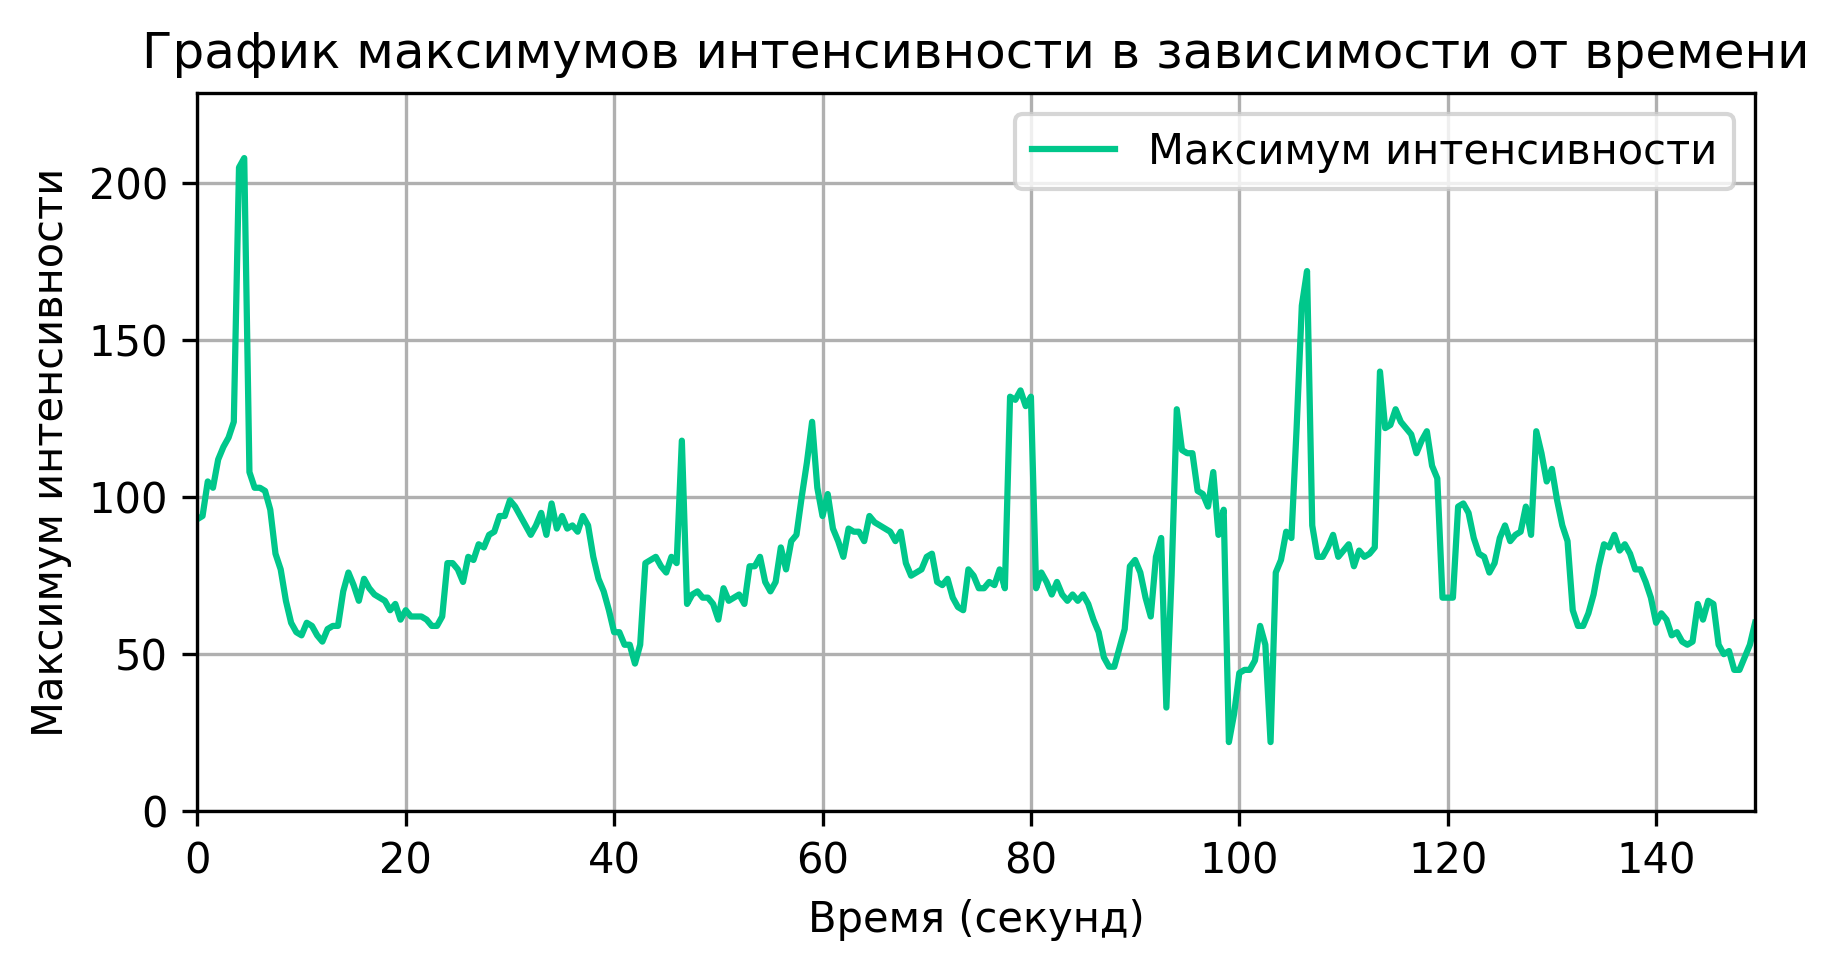

[[12  9  7 ...  5  5  5]
 [11  9  7 ...  5  5  5]
 [11  8  7 ...  5  5  5]
 ...
 [ 4  3  2 ...  5  5  5]
 [ 4  3  2 ...  5  5  5]
 [ 5  3  2 ...  5  5  5]]


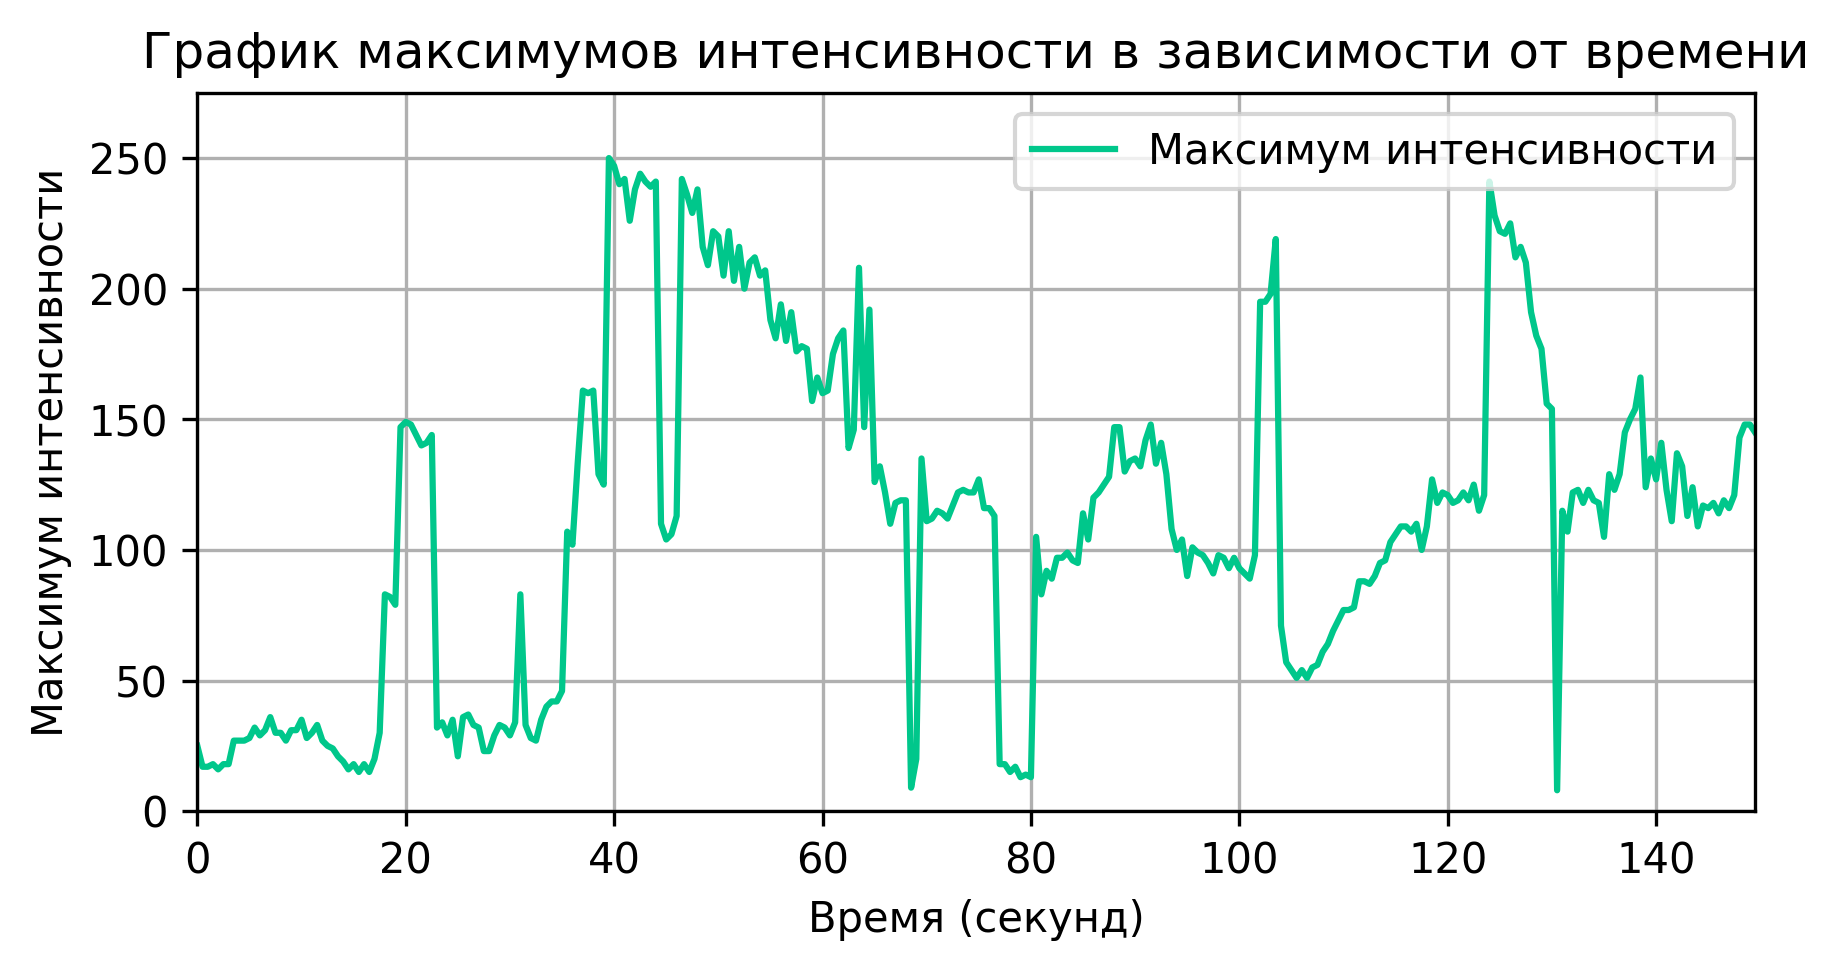

[[116 112 107 ...  45  44  44]
 [120 114 106 ...  44  43  43]
 [123 115 104 ...  44  43  42]
 ...
 [ 63  63  62 ...  95  94  94]
 [ 58  58  58 ...  93  92  91]
 [ 54  54  55 ...  91  90  89]]


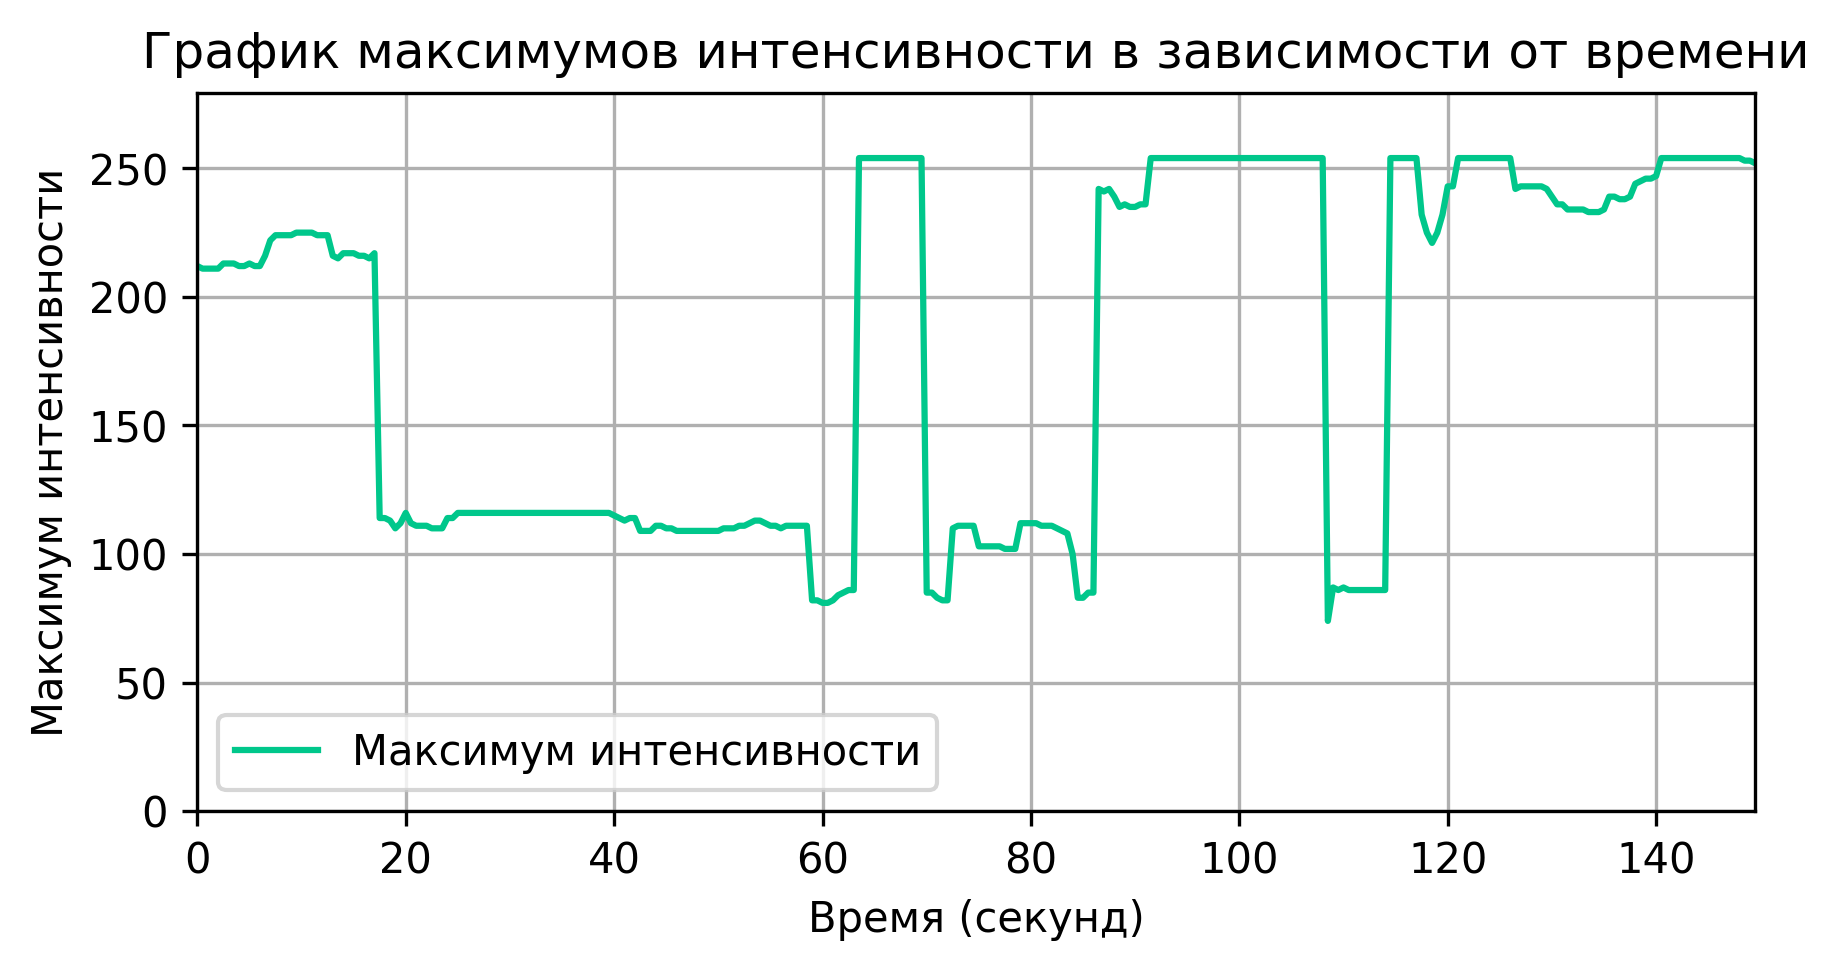

[[ 38  38  39 ... 102 104 106]
 [ 38  39  40 ... 107 109 110]
 [ 39  40  42 ... 112 114 115]
 ...
 [ 85  86  86 ... 114 114 114]
 [ 85  85  86 ... 114 113 113]
 [ 85  85  86 ... 113 113 113]]


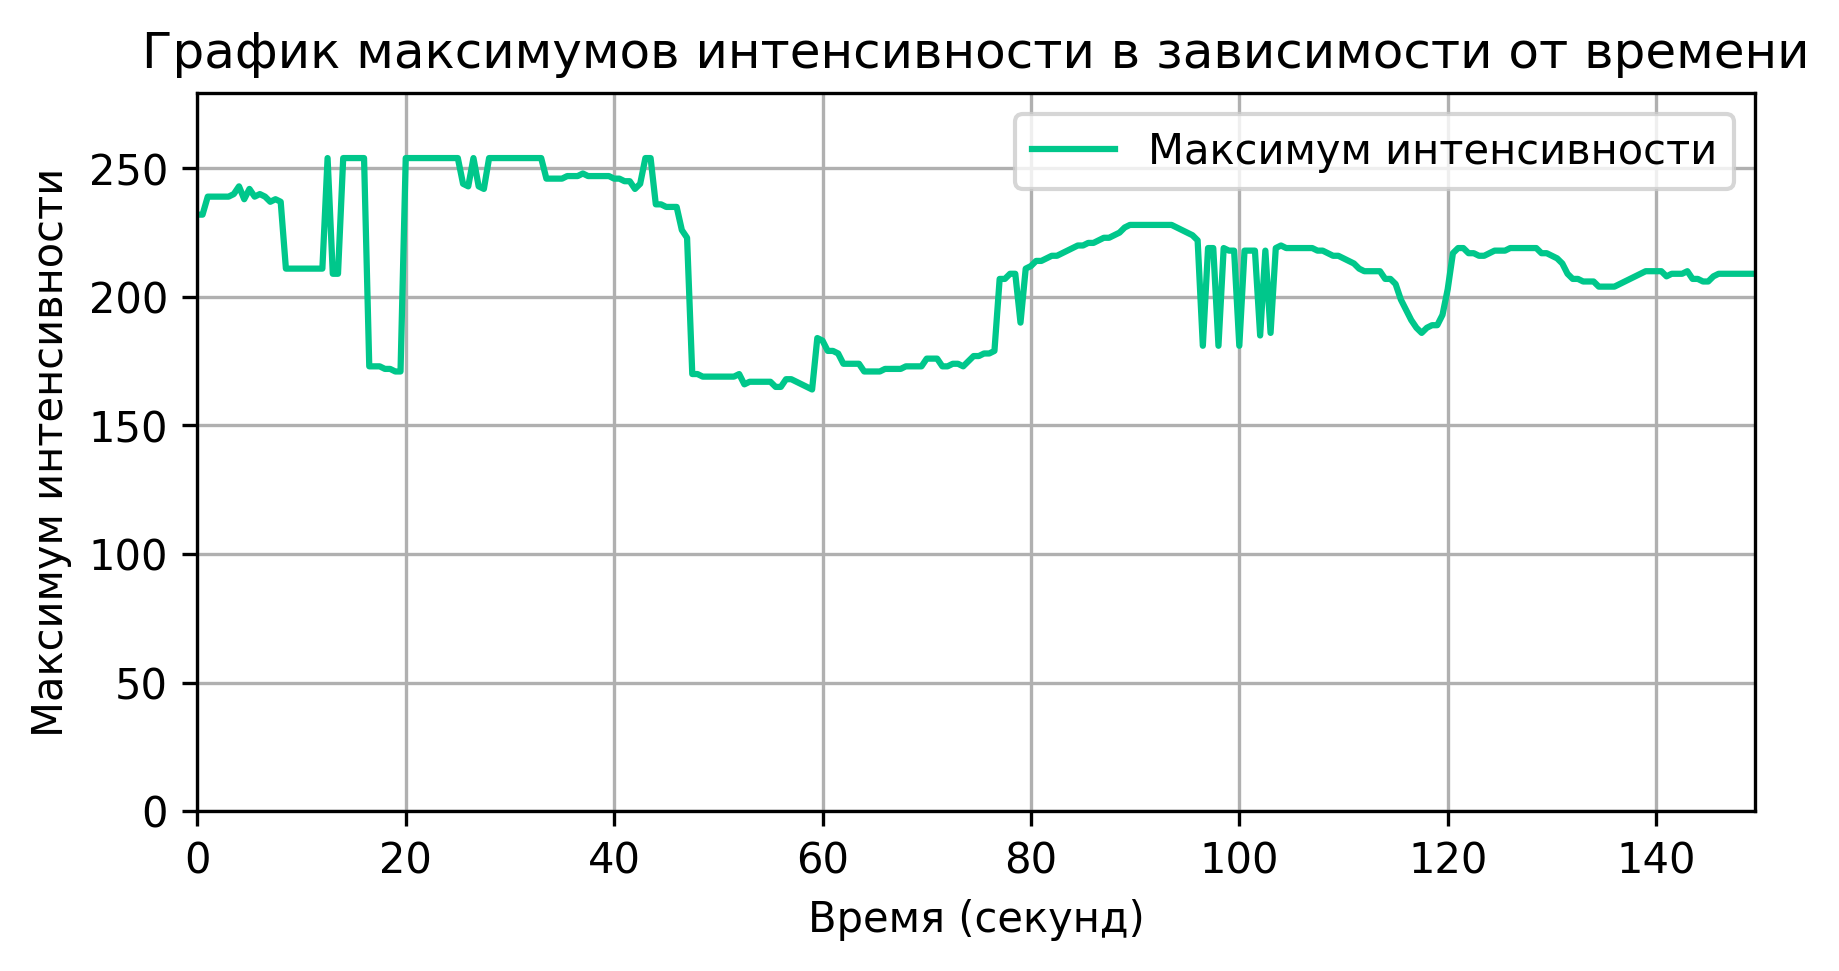

[[ 85  90  96 ...  91  80  72]
 [ 85  90  96 ... 109 100  91]
 [ 86  90  96 ... 124 118 111]
 ...
 [ 63  63  63 ...  48  43  40]
 [ 65  65  64 ...  37  33  31]
 [ 66  66  66 ...  29  27  26]]


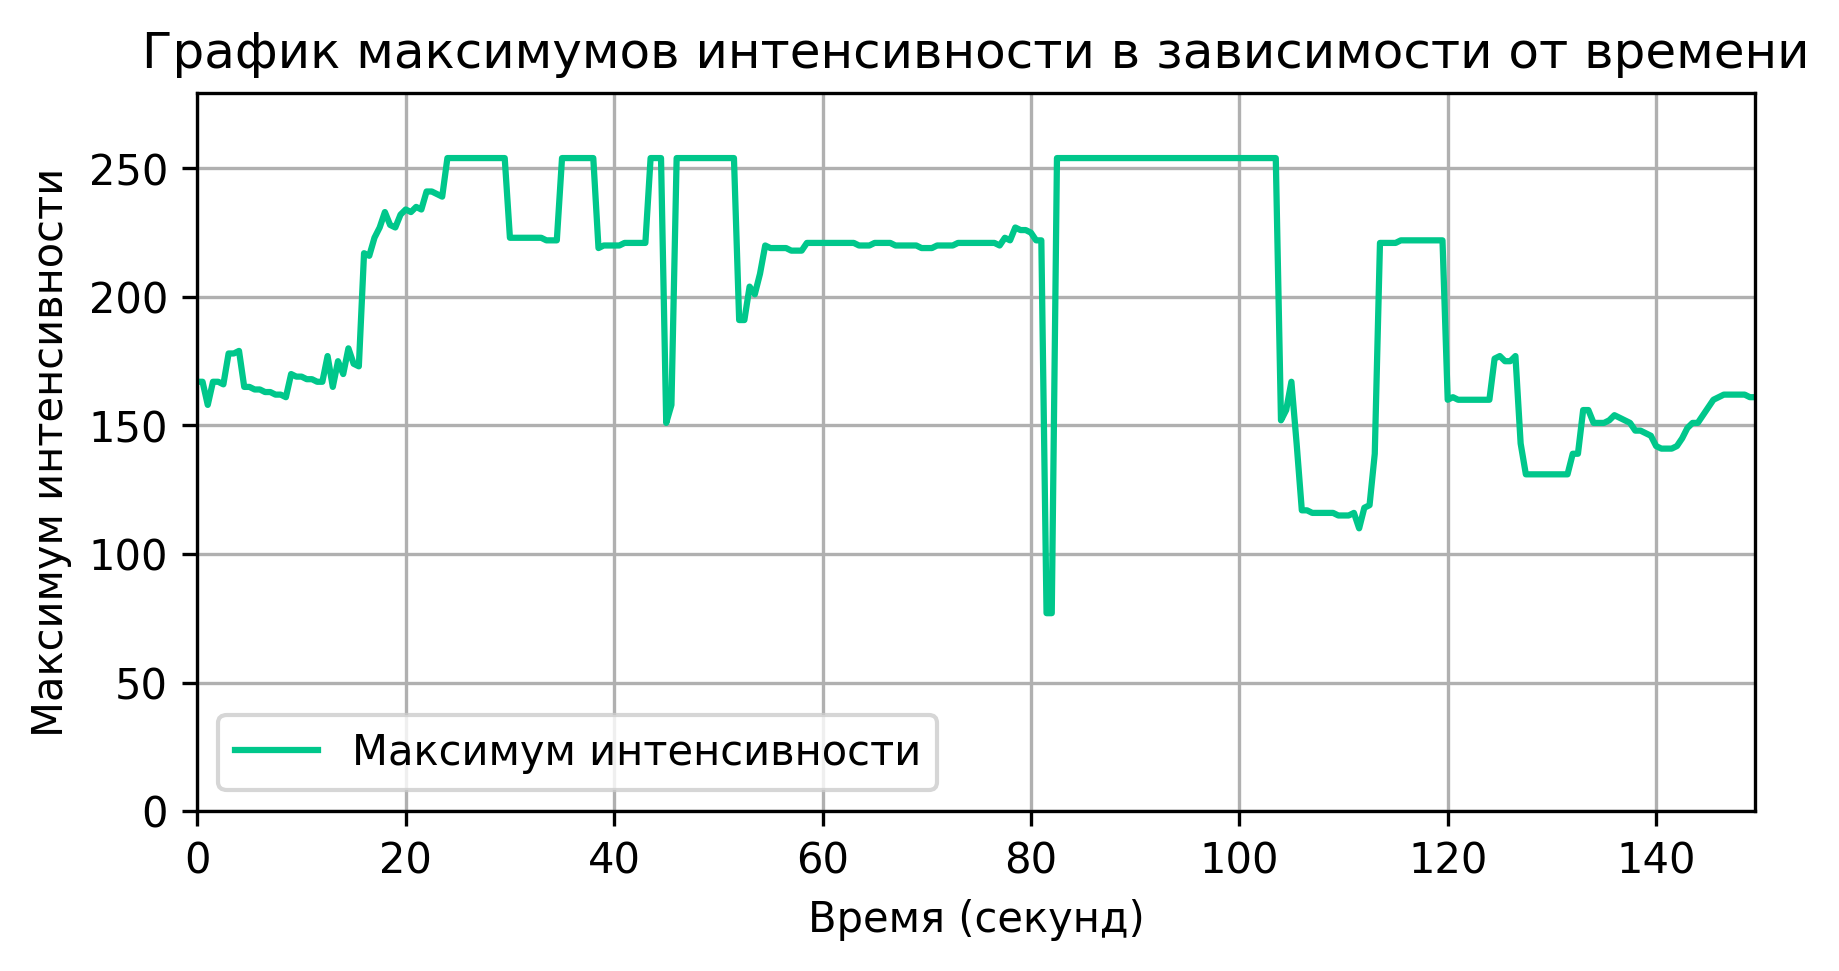

[[57 57 57 ... 60 60 60]
 [55 55 56 ... 60 60 60]
 [53 54 54 ... 61 61 61]
 ...
 [32 32 32 ... 53 53 53]
 [32 32 32 ... 53 53 54]
 [32 32 32 ... 54 54 54]]


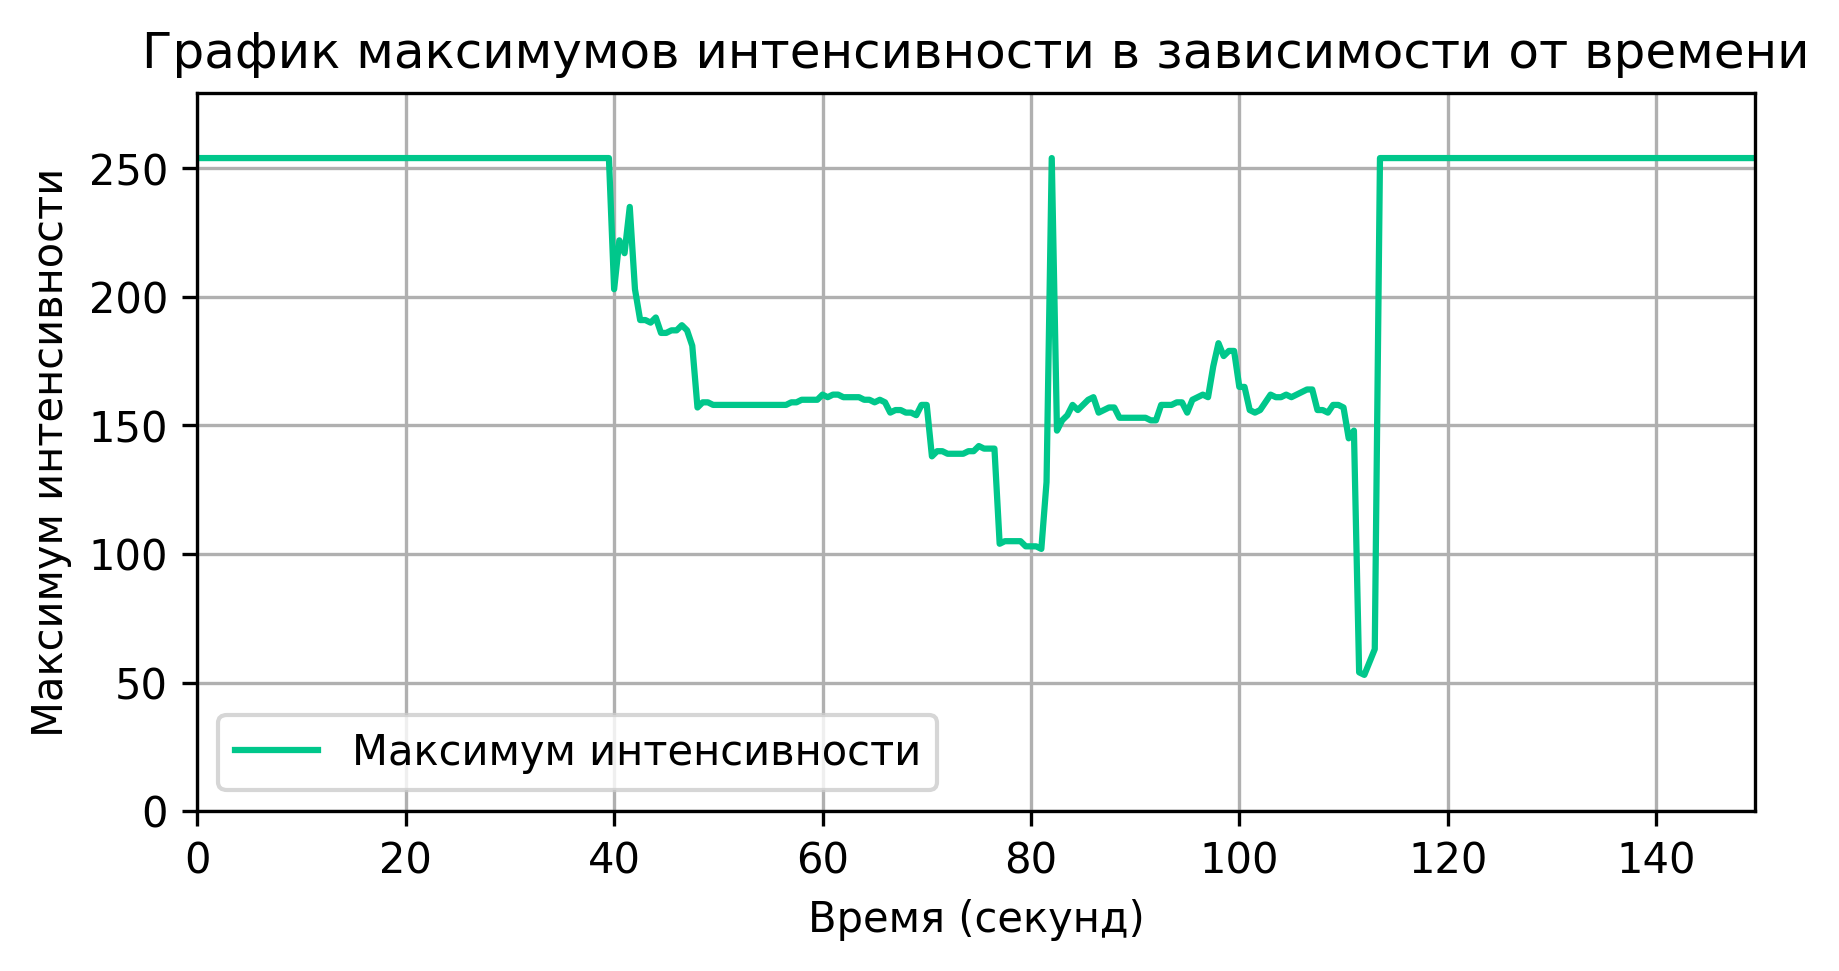

In [22]:
main_folder_path = r"D:\Python\last\main_folder"
final_func(main_folder_path)

### Запуск функций с помощью модулей

[[3 3 1 ... 4 4 4]
 [3 2 1 ... 4 4 4]
 [3 2 1 ... 3 4 3]
 ...
 [2 2 1 ... 3 3 3]
 [2 2 1 ... 3 3 3]
 [2 2 1 ... 3 3 3]]


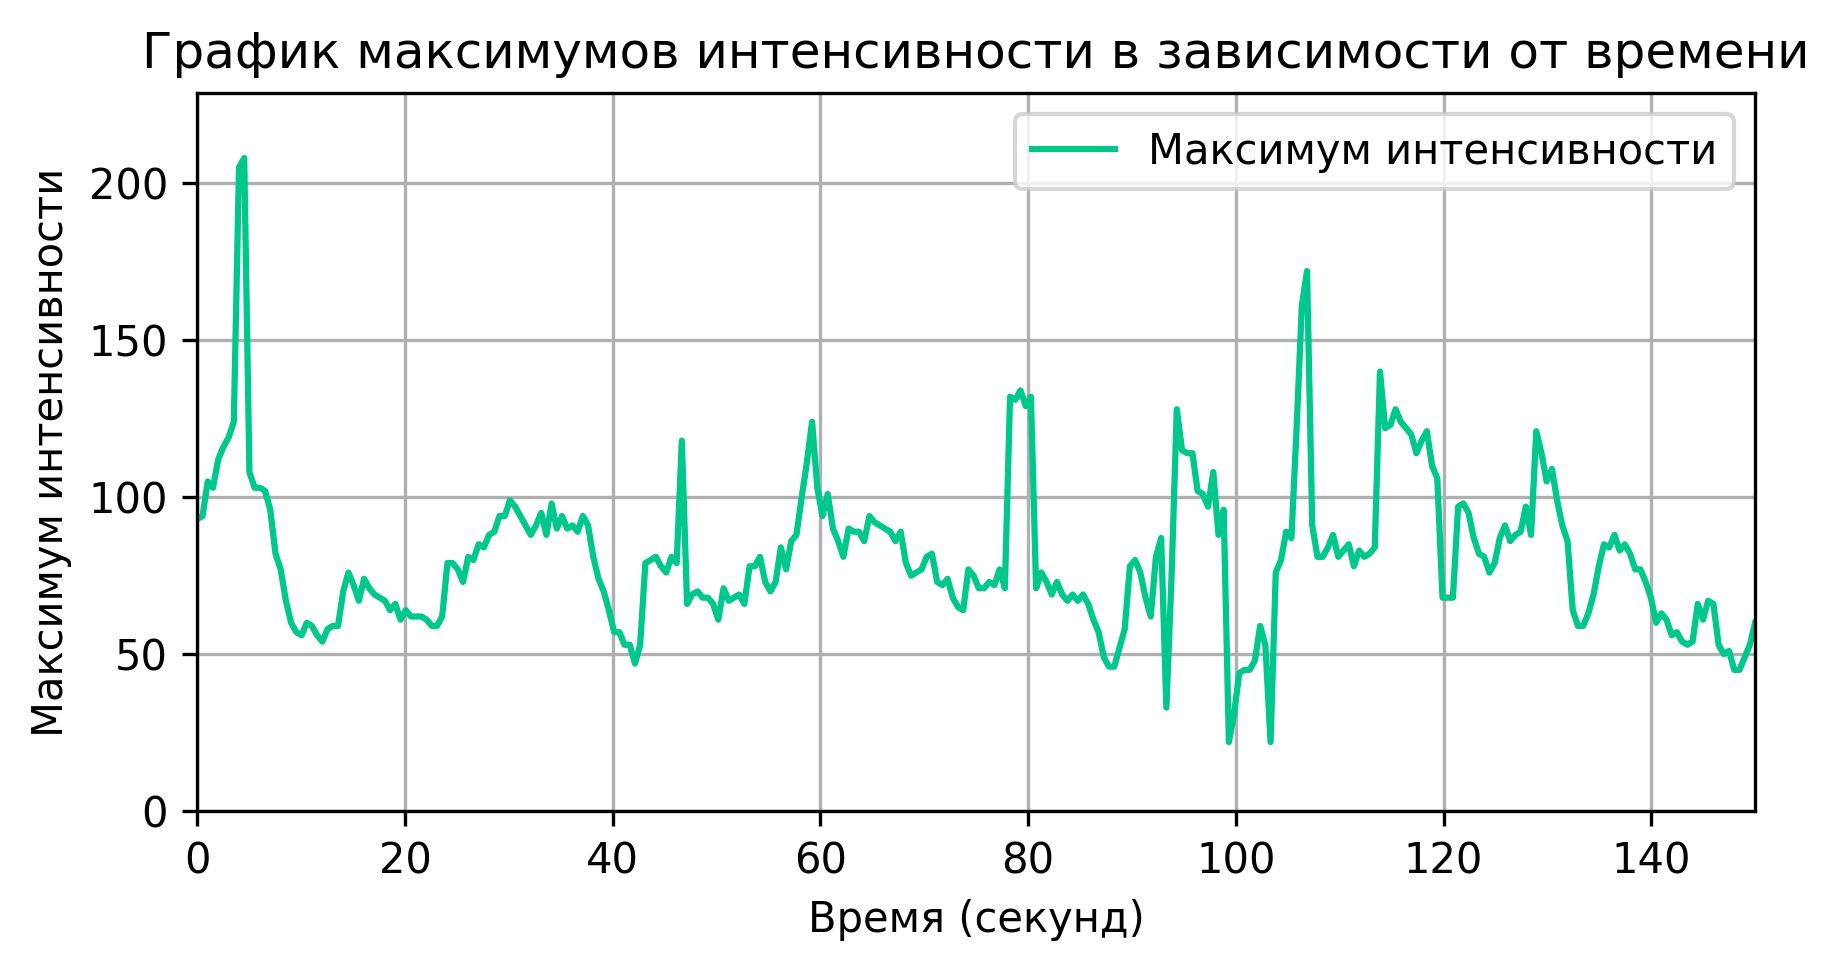

[[12  9  7 ...  5  5  5]
 [11  9  7 ...  5  5  5]
 [11  8  7 ...  5  5  5]
 ...
 [ 4  3  2 ...  5  5  5]
 [ 4  3  2 ...  5  5  5]
 [ 5  3  2 ...  5  5  5]]


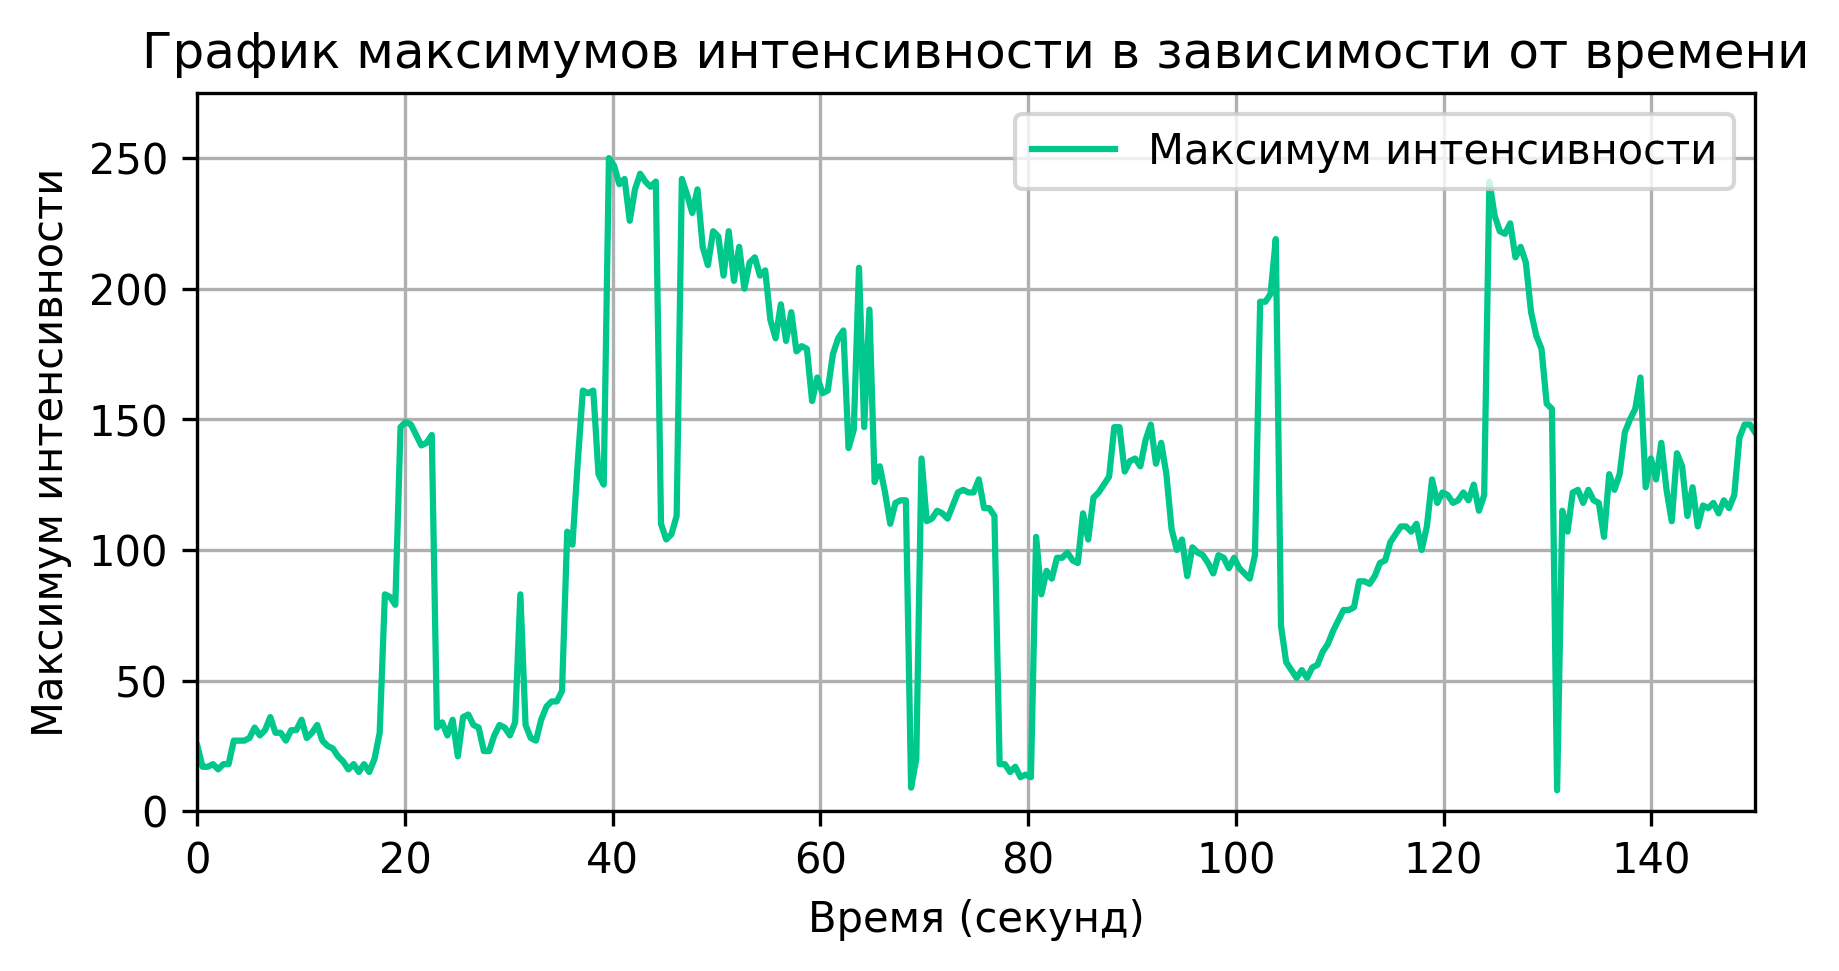

[[116 112 107 ...  45  44  44]
 [120 114 106 ...  44  43  43]
 [123 115 104 ...  44  43  42]
 ...
 [ 63  63  62 ...  95  94  94]
 [ 58  58  58 ...  93  92  91]
 [ 54  54  55 ...  91  90  89]]


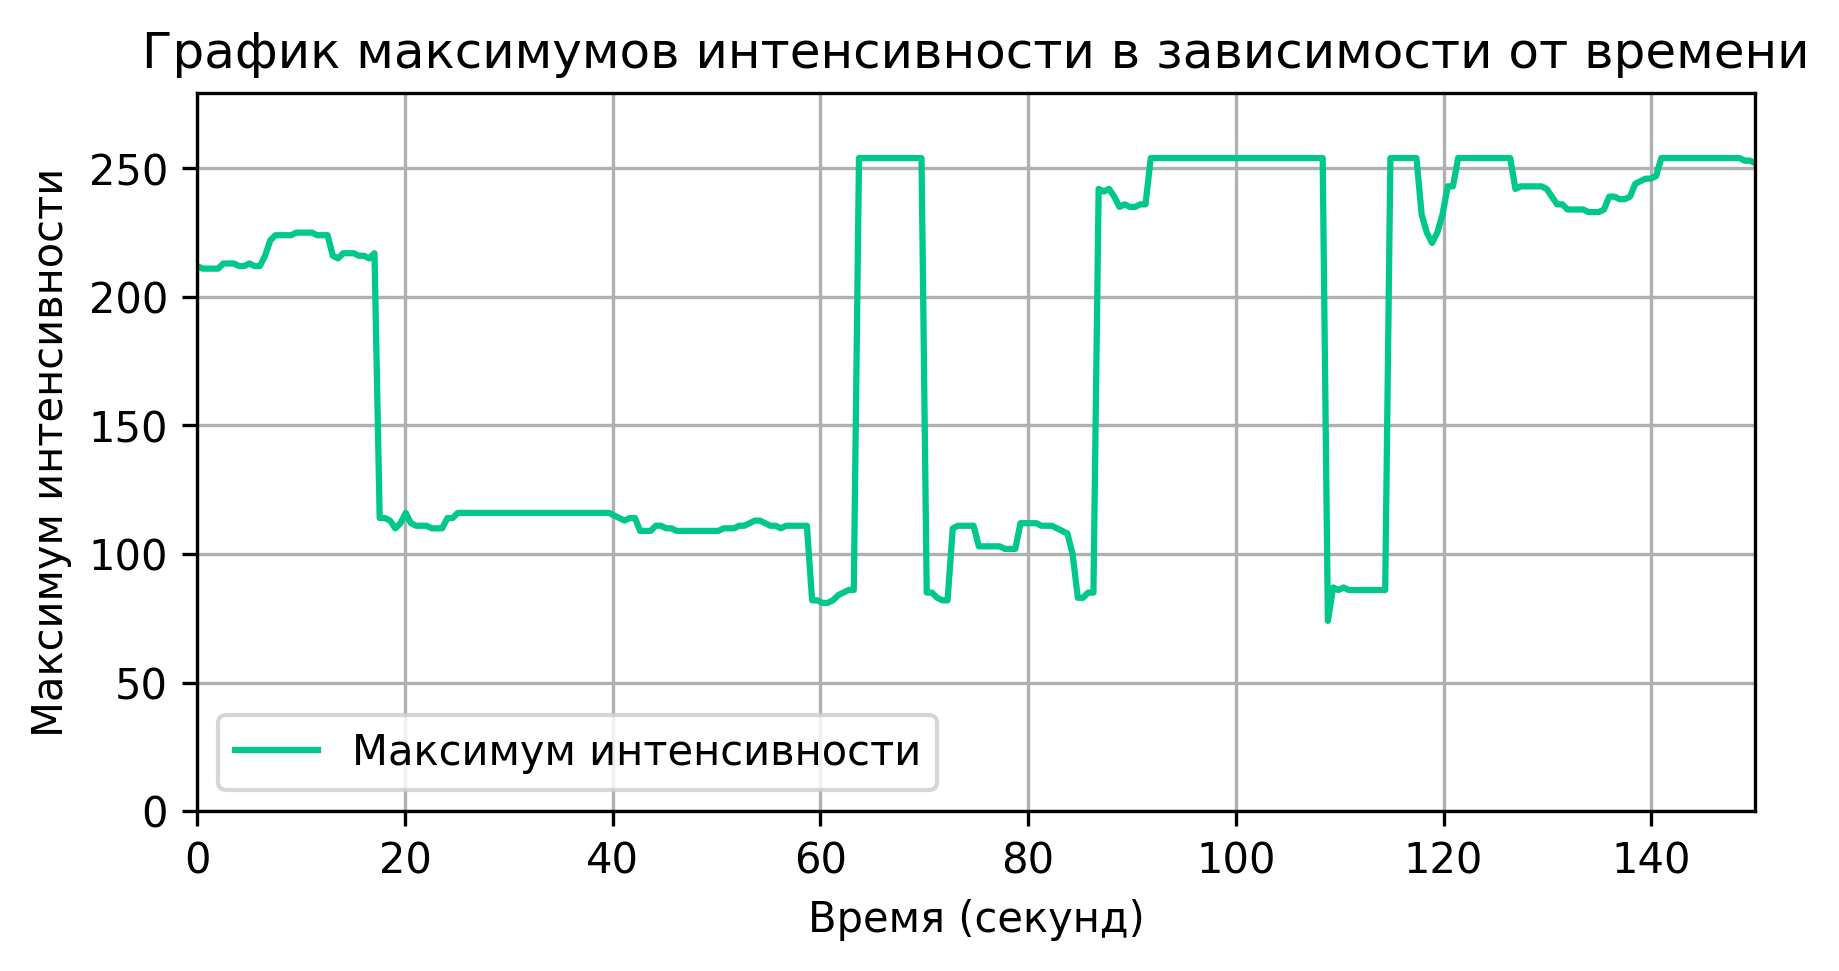

[[ 38  38  39 ... 102 104 106]
 [ 38  39  40 ... 107 109 110]
 [ 39  40  42 ... 112 114 115]
 ...
 [ 85  86  86 ... 114 114 114]
 [ 85  85  86 ... 114 113 113]
 [ 85  85  86 ... 113 113 113]]


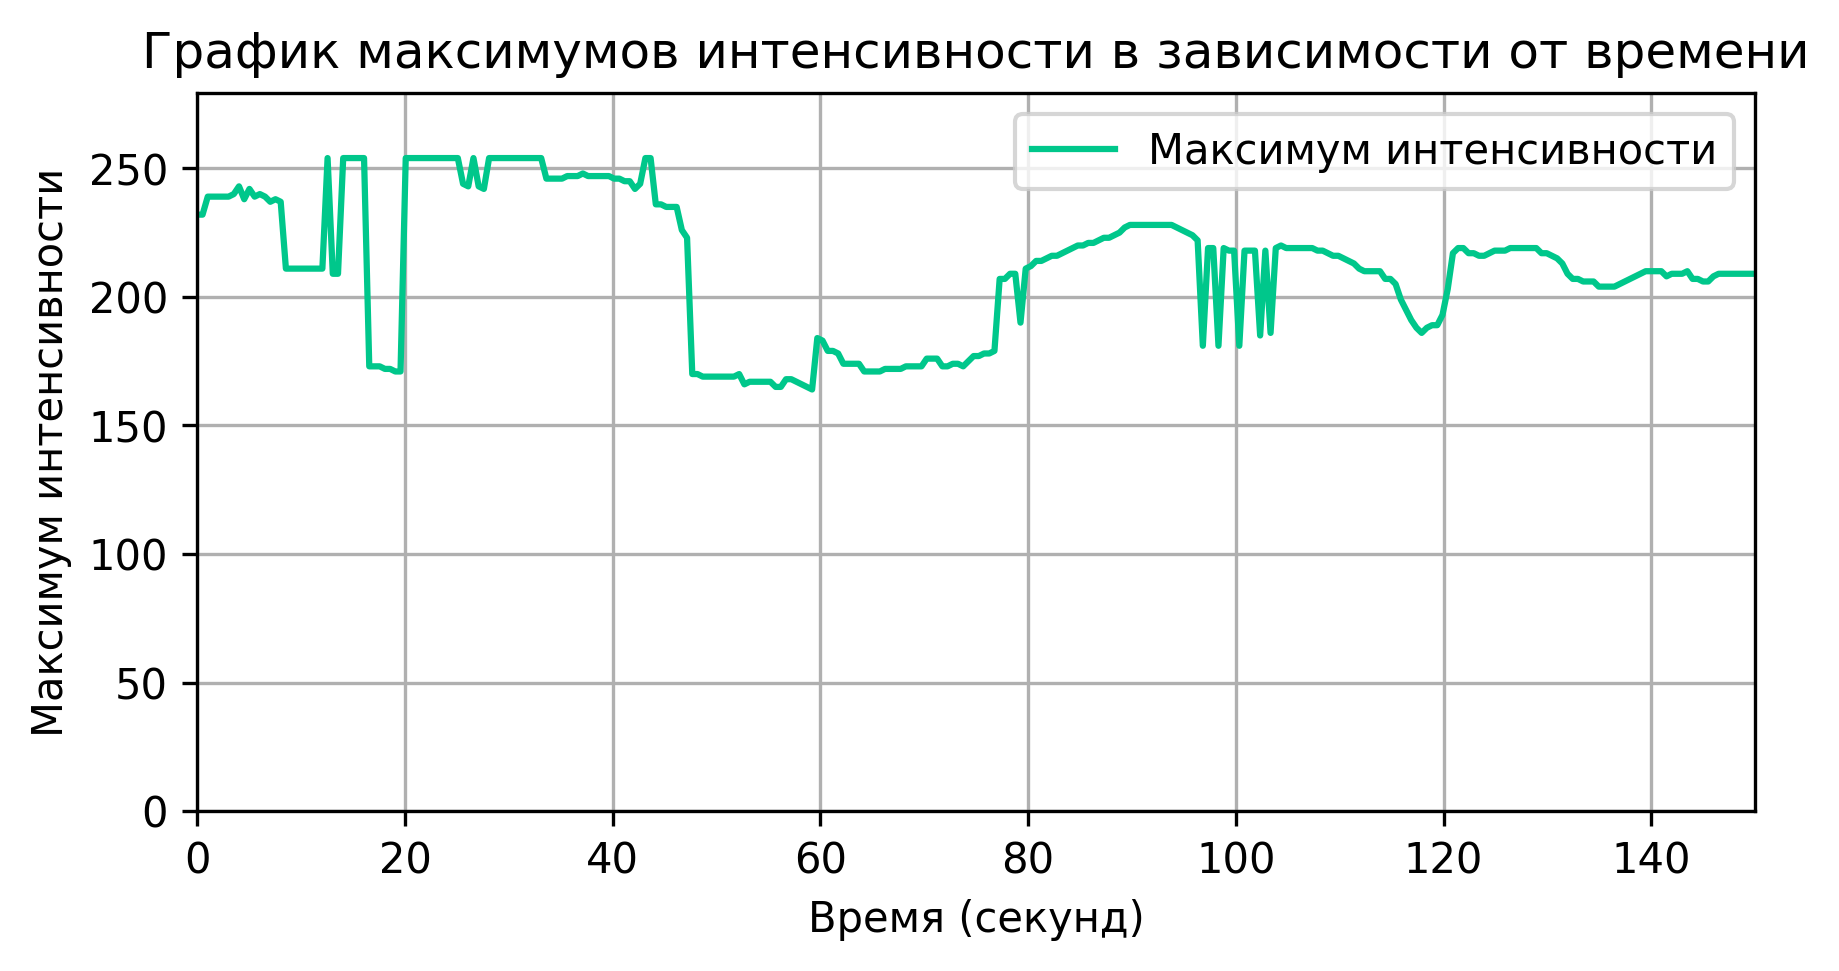

[[ 85  90  96 ...  91  80  72]
 [ 85  90  96 ... 109 100  91]
 [ 86  90  96 ... 124 118 111]
 ...
 [ 63  63  63 ...  48  43  40]
 [ 65  65  64 ...  37  33  31]
 [ 66  66  66 ...  29  27  26]]


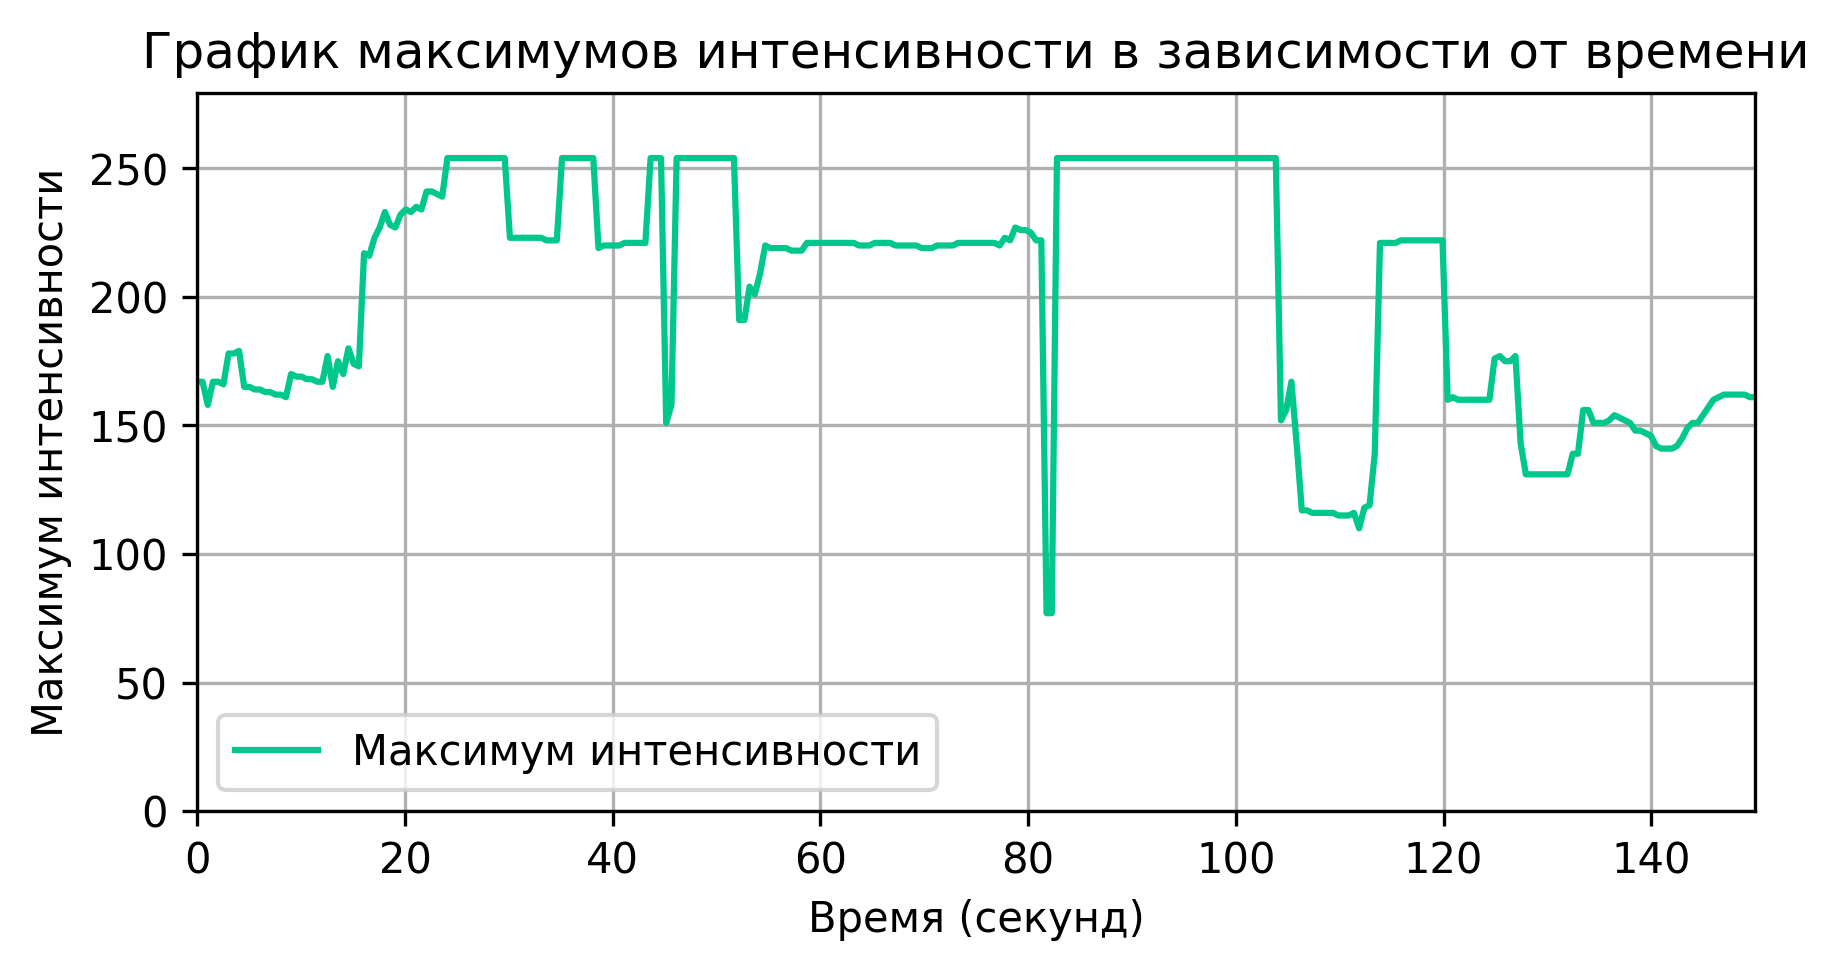

[[57 57 57 ... 60 60 60]
 [55 55 56 ... 60 60 60]
 [53 54 54 ... 61 61 61]
 ...
 [32 32 32 ... 53 53 53]
 [32 32 32 ... 53 53 54]
 [32 32 32 ... 54 54 54]]


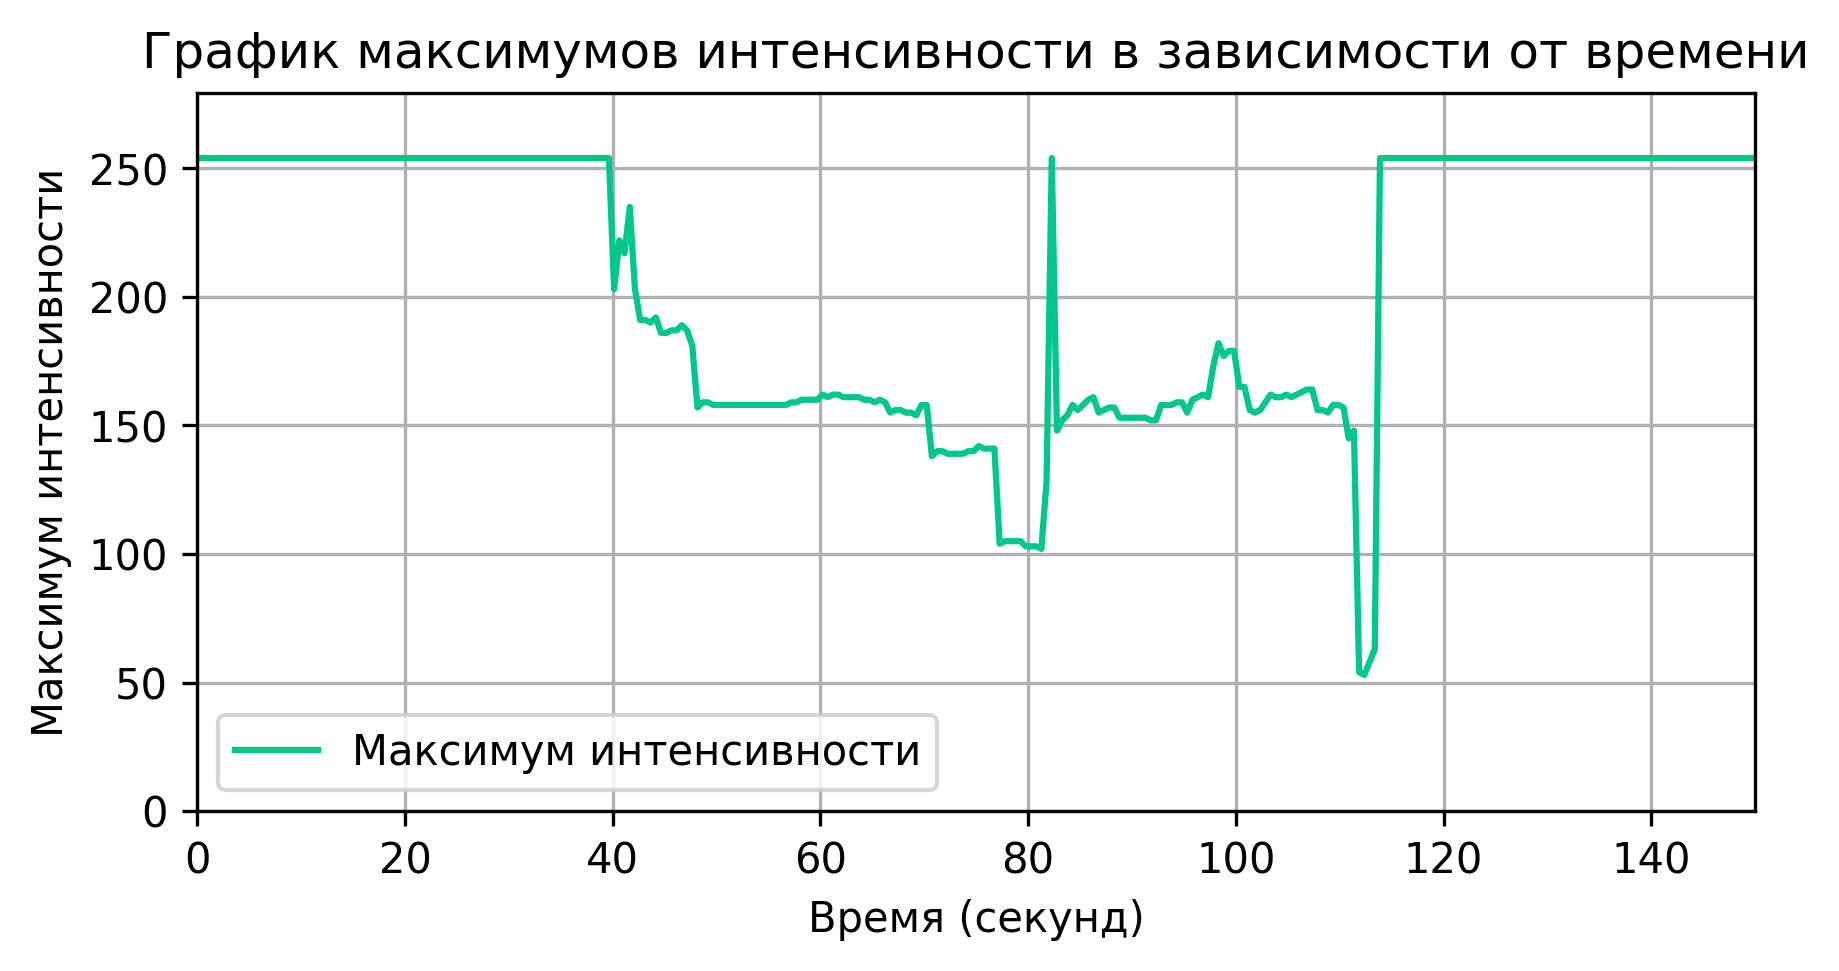

In [23]:
import astrocyti_package.core.main as astrocyti_main

main_folder_path = r"D:\Python\last\main_folder"
astrocyti_main.final_func(main_folder_path)

### Ссылка на github репозиторий
https://github.com/TheSubDex/astrocyti_solution

### Ссылка на отчёт

https://github.com/TheSubDex/astrocyti_solution/blob/main/Astrocyti_ot4et.docx